Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Already extracted.
Found 4534 images belonging to 30 classes.
Found 450 images belonging to 30 classes.
🔍 Using GPU: /device:GPU:0


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


142/142 - 332s - 2s/step - accuracy: 0.0505 - loss: 3.3973 - top_k_categorical_accuracy: 0.1403 - val_accuracy: 0.0356 - val_loss: 3.4416 - val_top_k_categorical_accuracy: 0.0978
Epoch 2/15
142/142 - 130s - 915ms/step - accuracy: 0.1156 - loss: 3.2080 - top_k_categorical_accuracy: 0.2642 - val_accuracy: 0.0533 - val_loss: 3.3854 - val_top_k_categorical_accuracy: 0.1511
Epoch 3/15
142/142 - 134s - 943ms/step - accuracy: 0.2210 - loss: 2.9895 - top_k_categorical_accuracy: 0.4140 - val_accuracy: 0.2089 - val_loss: 3.0925 - val_top_k_categorical_accuracy: 0.3778
Epoch 4/15
142/142 - 131s - 920ms/step - accuracy: 0.3419 - loss: 2.6856 - top_k_categorical_accuracy: 0.5589 - val_accuracy: 0.4489 - val_loss: 2.5738 - val_top_k_categorical_accuracy: 0.6778
Epoch 5/15
142/142 - 130s - 917ms/step - accuracy: 0.4508 - loss: 2.3475 - top_k_categorical_accuracy: 0.6802 - val_accuracy: 0.4667 - val_loss: 2.3783 - val_top_k_categorical_accuracy: 0.7111
Epoch 6/15
142/142 - 137s - 966ms/step - accuracy

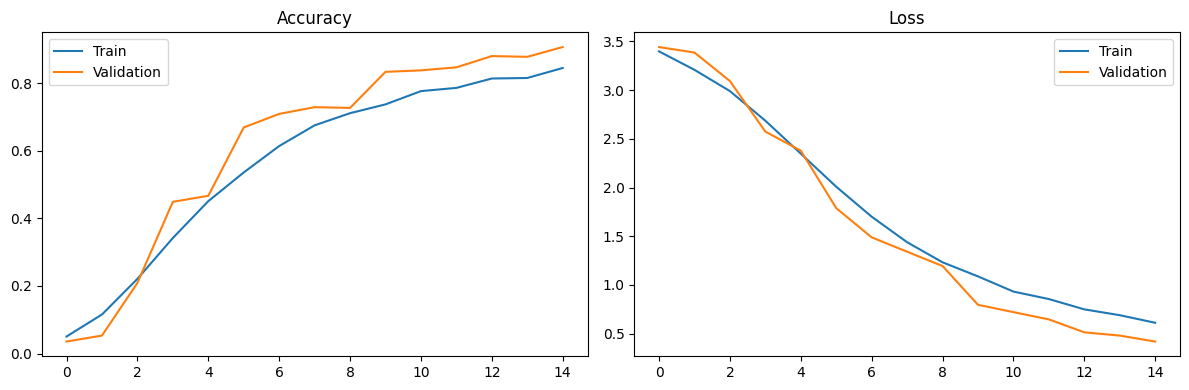

In [ ]:
# ======================
# 0. GOOGLE DRIVE & EXTRACTION
# ======================
from google.colab import drive
drive.mount('/content/drive')

import zipfile, os

# Path to your ZIP file inside Google Drive
zip_path = "/content/drive/MyDrive/merged.zip"  # Update if needed
extract_path = "/content/merged"

# Extract only if not already extracted
if not os.path.exists(os.path.join(extract_path, "merged")):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Extracted!")
else:
    print("✅ Already extracted.")

# ======================
# 1. SETUP
# ======================
!pip install tensorflow -q
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import pickle
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Enable XLA
tf.config.optimizer.set_jit(True)

# GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

# ======================
# 2. PATHS & PARAMS
# ======================
DATA_DIR = "/content/merged/merged"
TARGET_SIZE = (300, 300)
BATCH_SIZE = 32
EPOCHS = 15

train_dir = os.path.join(DATA_DIR, "train")
val_dir = os.path.join(DATA_DIR, "validate")

# Save paths
MODEL_PATH = "/content/drive/MyDrive/best_model.keras"
HISTORY_PATH = "/content/drive/MyDrive/history.pkl"
CLASS_INDICES_PATH = "/content/drive/MyDrive/class_indices.json"

# ======================
# 3. DATA LOADERS
# ======================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Save class label mapping
with open(CLASS_INDICES_PATH, "w") as f:
    json.dump(train_gen.class_indices, f)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(train_gen.class_indices)),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))

# ======================
# 4. MODEL
# ======================
def build_model():
    base_model = EfficientNetB3(
        include_top=False,
        weights='imagenet',
        input_shape=(*TARGET_SIZE, 3),
        pooling='avg'
    )
    base_model.trainable = True  # Unfreeze from beginning

    x = layers.Dense(256, activation='relu')(base_model.output)
    x = layers.Dropout(0.4)(x)
    output = layers.Dense(train_gen.num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output)
    return model

model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)]
)

# ======================
# 5. CALLBACKS
# ======================
callbacks = [
    EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
    ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_accuracy')
]

# ======================
# 6. TRAINING
# ======================
print("🔍 Using GPU:", tf.test.gpu_device_name())
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2,
    class_weight=class_weights
)

# Save history to Drive
with open(HISTORY_PATH, 'wb') as f:
    pickle.dump(history.history, f)

# ======================
# 7. EVALUATION
# ======================
model = tf.keras.models.load_model(MODEL_PATH)
val_loss, val_acc, val_top3 = model.evaluate(val_gen)
print(f"\n★ Validation Accuracy: {val_acc:.2%}")
print(f"★ Top-3 Accuracy: {val_top3:.2%}")

# ======================
# 8. PLOT TRAINING
# ======================
plt.figure(figsize=(12,4))

# Accuracy Plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/final_model.h5")
model.save("/content/drive/MyDrive/final_model.keras")


TypeError: cannot pickle 'module' object

In [ ]:
import tensorflow as tf
print("GPU:", tf.config.list_physical_devices('GPU'))


GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
model.summary()

NameError: name 'model' is not defined

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/my-drive/best_model.keras")
model.summary()

ValueError: File not found: filepath=/content/drive/my-drive/best_model.keras. Please ensure the file is an accessible `.keras` zip file.